In [1]:
NORMAL_DRIVING_PATH = './data2/normal/'
CORRECTIN_DRIVING_PATH = './data2/correcting/'
REVERSE_DRIVING_PATH = './data2/reverse/'

In [2]:
import csv
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def get_lines(path):
    lines = []
    with open ('%sdriving_log.csv' % path) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)
        return lines


normal_lines = get_lines(NORMAL_DRIVING_PATH)
correction_lines = get_lines(CORRECTIN_DRIVING_PATH)
reverse_lines = get_lines(REVERSE_DRIVING_PATH)
print(normal_lines[0][0].split('/')[-1])
print(correction_lines[0][0].split('/')[-1])
print(reverse_lines[0][0].split('/')[-1])



center_2017_10_30_21_29_19_463.jpg
center_2017_10_30_21_39_16_694.jpg
center_2017_10_30_21_23_19_570.jpg


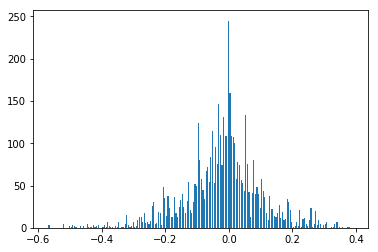

In [3]:
# Let's look at the distribution of angles
def plot_histogram(labels, bins):
    history, bins = np.histogram(labels, bins)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, history, align='center', width=width)
    plt.show()

# Let's find the min and max angles
all_lines = np.asarray(normal_lines + correction_lines + reverse_lines)
angles = all_lines[:,3].astype(np.float)
min_angle = np.amin(angles)
max_angle = np.amax(angles)
bins = np.arange(min_angle, max_angle, step=0.005)

plot_histogram(angles, bins)

In [103]:
def load_image(img_full_path):
    # Name of the img, e.g. center_2017_10_24_17_22_37_747.jpg
    name = img_full_path.split('/')[-1]

    # Mode, i.e. normal, correcting, reverse
    dataset = img_full_path.split('/')[-3]

    path = './data2/%s/IMG/%s' % (dataset, name)
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
    

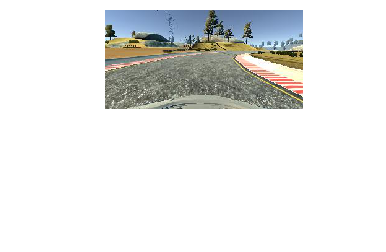

In [104]:
import matplotlib.pyplot as plt
%matplotlib inline

sample_img = load_image(reverse_lines[0][0])

fig, ax = plt.subplots(nrows=2)
ax = ax.ravel()
ax[0].imshow(sample_img)

for a in ax:
    a.axis('off')

In [65]:
import numpy as np
from skimage import transform

def random_translate(img, steering_angle, is_debug=False):
    random_x = np.random.randint(-50, 50)
    random_y = np.random.randint(-25, 25)
    steering_angle = steering_angle + random_x * 0.004
    tform = transform.SimilarityTransform(translation=(random_x, random_y))
    translated = transform.warp(img, tform)
    if is_debug:
        print('Random X: %s, Random Y: %s, Steering Angle Adjustment: %s' %(random_x, random_y, steering_angle))
    return translated, steering_angle

In [100]:
def random_brightness(img):
    img = np.array(img, dtype=np.uint8)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    brightness = .25 + np.random.uniform()
    hsv[:,:,2] = hsv[:,:,2] * brightness
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

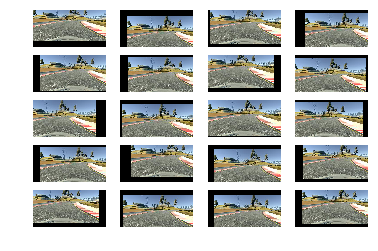

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
%matplotlib inline


sample_img = load_image(reverse_lines[0][0])
steering_angle = 0
fig, ax = plt.subplots(nrows=5, ncols=4)

ax = ax.ravel()

for i in range(0, 20):
    translated, _ = random_translate(sample_img, steering_angle)
    ax[i].imshow(translated)

for a in ax:
    a.axis('off')

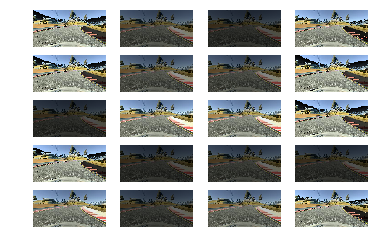

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
%matplotlib inline


sample_img = load_image(reverse_lines[0][0])
steering_angle = 0
fig, ax = plt.subplots(nrows=5, ncols=4)

ax = ax.ravel()

for i in range(0, 20):
    bright = random_brightness(sample_img)
    ax[i].imshow(bright)

for a in ax:
    a.axis('off')

In [83]:
CENTER = 0
LEFT = 1
RIGHT = 2
ANGLE = 3
LEFT_ANGLE_CORRECTION = 0.25
RIGHT_ANGLE_CORRECTION = -0.25

def get_training_image(line):
    camera = np.random.randint(CENTER, RIGHT + 1)
    camera_img = load_image(line[camera])
    angle = float(line[ANGLE])

    steering_correction = 0.0

    if camera is LEFT:
        steering_correction = LEFT_ANGLE_CORRECTION
    elif camera is RIGHT:
        steering_correction = RIGHT_ANGLE_CORRECTION

    return camera_img, angle + steering_correction
    

In [84]:
samples = 100
size = 10
for offset in range(0, samples, size):
    num_iterations = int(samples/ size)
    print((offset) / samples)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [85]:
CENTER = 0
LEFT = 1
RIGHT = 2
ANGLE = 3
LEFT_ANGLE_CORRECTION = 0.25
RIGHT_ANGLE_CORRECTION = -0.25

In [144]:
def make_validation_generator(data, batch_size=256):
    while True:
        num_samples = len(data)
        data = sklearn.utils.shuffle(data)
        for offset in range(0, num_samples, batch_size):
            batch_samples = data[offset:offset+batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                img = load_image(batch_sample[CENTER])
                angle = float(batch_sample[ANGLE])
                images.append(img)
                angles.append(angle)
            x_images = np.array(images)
            y_labels = np.array(angles)
            yield x_images, y_labels
                

In [143]:
import sklearn.utils

used_angles = []
dropped_angles = []

def make_train_generator(data, batch_size=256, with_dropping=False):
    num_samples = len(data)
    global used_angles
    global dropped_angles
    
    used_angles = []
    dropped_angles = []
    while True:
        data = sklearn.utils.shuffle(data)
        for offset in range(0, num_samples, batch_size):
            batch_samples = data[offset:offset+batch_size]
            
            if with_dropping:
                pass
                #print('\nKeep probability is %s\n' % (offset / num_samples))
            
            images = []
            angles = []
            for batch_sample in batch_samples:

                keep_small_angle_probability = offset / num_samples
                img, angle = get_training_image(batch_sample)
                
                while with_dropping and True:
                    if angle > -0.2 and angle < 0.2:
                        should_keep = np.random.uniform(0, 1) <= keep_small_angle_probability
                        if should_keep:
                            break
                        else:
                            #print('Regenerating: %s' % keep_small_angle_probability)
                            img, angle = get_training_image(batch_sample)
                    else:
                        break

                images.append(img)
                angles.append(angle)
                
                # Apply some random brightness and translation.
                augmented_img = random_brightness(img)
                augmented_img, augmented_angle = random_translate(augmented_img, angle)
                augmented_img = random_brightness(augmented_img)

                # Maybe flip the image
                if np.random.randint(2):
                    augmented_img = np.fliplr(augmented_img)
                    augmented_angle *= -1

                images.append(augmented_img)
                angles.append(augmented_angle * -1)
                
                #images.append(right_img)
                #angles.append(angle + RIGHT_ANGLE_CORRECTION)
                #images.append(cv2.flip(right_img, 1))
                #angles.append((angle + RIGHT_ANGLE_CORRECTION) * -1)
            
            x_images = np.array(images)
            y_labels = np.array(angles)
            if with_dropping:
                dropped_angles = dropped_angles + angles
            else:
                used_angles = used_angles + angles
            yield sklearn.utils.shuffle(x_images, y_labels)
        

In [145]:
from sklearn.model_selection import train_test_split

# Combine all the data lines together.
all_lines = normal_lines + correction_lines + reverse_lines

train_samples, validation_samples = train_test_split(all_lines, test_size=0.2)
train_generator = make_train_generator(train_samples, batch_size=256)
validation_generator = make_validation_generator(validation_samples, batch_size=256)

In [146]:
# Same as above, but with dropping
from sklearn.model_selection import train_test_split

# Combine all the data lines together.
all_lines = normal_lines + correction_lines + reverse_lines

train_samples_dropping, validation_samples_dropping = train_test_split(all_lines, test_size=0.2)
train_generator_dropping = make_train_generator(train_samples_dropping, batch_size=256, with_dropping=True)
validation_generator_dropping = make_validation_generator(validation_samples_dropping, batch_size=256)

In [147]:
def resize(img):
    import tensorflow as tf
    return tf.image.resize_images(img, (66, 200))

In [148]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, SpatialDropout2D
from keras.layers.convolutional import Convolution2D
from keras.layers import Cropping2D, Lambda, Reshape, Dropout
from keras.optimizers import Adam

def run_model(train, valid, name):
    model = Sequential()
    # Shave 50px from the top and 20px from the bottom to be left with a 90x320x img
    model.add(Cropping2D(cropping=((50, 20), (0, 0)), input_shape=(160, 320, 3)))

    # Resize the image to match the nvidia sizes.
    model.add(Lambda(resize))

    # Normalize the image.
    model.add(Lambda(lambda x: x/255.0 - 0.5))
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), name='conv1', activation='elu'))
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), name='conv2', activation='elu'))
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), name='conv3', activation='elu'))
    model.add(SpatialDropout2D(0.5))
    model.add(Convolution2D(64, 3, 3, name='conv4', activation='elu'))
    model.add(SpatialDropout2D(0.5))
    model.add(Convolution2D(64, 3, 3, name='conv5', activation='elu'))

    model.add(Flatten())
    #model.add(Dense(1, activation='elu'))

    model.summary()

    model.add(Dense(1164, name='desn1164', activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(100, name='dense100'))
    model.add(Dropout(0.5))
    model.add(Dense(50, name='dense50'))
    model.add(Dropout(0.5))
    model.add(Dense(10, name='dense10'))
    model.add(Dense(1, name='dense1'))

    model.compile(loss='mse', optimizer=Adam(lr=0.001))
    model.fit_generator(
        train,
        samples_per_epoch=len(train_samples * 2),    # * 6 for center, left, and right image
        validation_data=valid,
        nb_val_samples=len(validation_samples * 1),  # * 6 for center, left, and right image
        nb_epoch=5)

    model.save(name)

In [40]:

run_model(train_generator, validation_generator, 'model.h5')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_4 (Cropping2D)        (None, 90, 320, 3)    0           cropping2d_input_4[0][0]         
____________________________________________________________________________________________________
lambda_7 (Lambda)                (None, 66, 200, 3)    0           cropping2d_4[0][0]               
____________________________________________________________________________________________________
lambda_8 (Lambda)                (None, 66, 200, 3)    0           lambda_7[0][0]                   
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 31, 98, 24)    1824        lambda_8[0][0]                   
___________________________________________________________________________________________

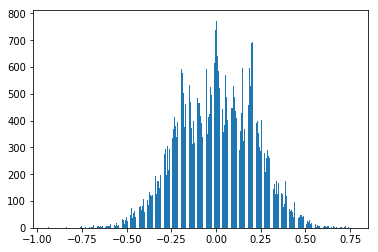

In [41]:
min_angle = np.amin(used_angles)
max_angle = np.amax(used_angles)
bins = np.arange(min_angle, max_angle, step=0.005)

plot_histogram(used_angles, bins)

In [149]:
run_model(train_generator_dropping, validation_generator_dropping, 'model_with_dropping.h5')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_16 (Cropping2D)       (None, 90, 320, 3)    0           cropping2d_input_16[0][0]        
____________________________________________________________________________________________________
lambda_31 (Lambda)               (None, 66, 200, 3)    0           cropping2d_16[0][0]              
____________________________________________________________________________________________________
lambda_32 (Lambda)               (None, 66, 200, 3)    0           lambda_31[0][0]                  
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 31, 98, 24)    1824        lambda_32[0][0]                  
___________________________________________________________________________________________

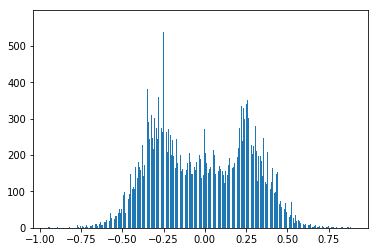

In [150]:
min_angle = np.amin(dropped_angles)
max_angle = np.amax(dropped_angles)
bins = np.arange(min_angle, max_angle, step=0.005)

plot_histogram(dropped_angles, bins)